In [1]:
import numpy as np
import scipy.stats as sts
from scipy import constants as cnst
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def create_art_vels(tTx, tTy, N_particles, metersPerPx, frps, ro, diam, drift_x, drift_y, left_x, right_x, bottom_y, top_y):
    import numpy as np
    import scipy.stats as sts
    from scipy import constants as cnst
    resol_SI = 1.0 / metersPerPx # camera resolution in px/meters
   
    dust_mass = 4.0 / 3.0 * np.pi * (diam / 2.0)**3 * ro #mass of the dust particles
    sigma_x = np.sqrt(cnst.k * tTx / dust_mass)
    sigma_y = np.sqrt(cnst.k * tTy / dust_mass)
    left_x_bord_SI = left_x / resol_SI
    right_x_bord_SI = right_x / resol_SI #coordinated of the right border
    bottom_y_bord_SI = bottom_y / resol_SI
    top_y_bord_SI = top_y / resol_SI
    
    time_step = 1.0 / frps


    #Creating the arrays to store data in:
    arr_ind = np.arange(0,N_particles,1,dtype = 'int') # array of particles ID numbers
    arr_first_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_first_frame_no = arr_first_frame_no + int(1)        #array to store the firs frame number
    arr_next_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_next_frame_no = arr_next_frame_no + int(2)        #array to store the next frame number

    #array to store the "nonexistent" data:

    arr_nan = np.empty(N_particles)
    arr_nan.fill(np.nan)
    
    

    artif_vx_rv = sts.norm(drift_x,sigma_x)
    artif_vy_rv = sts.norm(drift_y,sigma_y)
    
    arr_sample_vx = artif_vx_rv.rvs(N_particles)
    arr_sample_vy = artif_vy_rv.rvs(N_particles)

    #Array of artificial coordinates for the "previous" frame:
    arr_x_prev_rv = sts.uniform(left_x_bord_SI, right_x_bord_SI - left_x_bord_SI)
    arr_y_prev_rv = sts.uniform(bottom_y_bord_SI, top_y_bord_SI - bottom_y_bord_SI)
    arr_sample_prev_x = arr_x_prev_rv.rvs(N_particles)
    arr_sample_prev_y = arr_y_prev_rv.rvs(N_particles)

    arr_prev_x_inResolChunks = arr_sample_prev_x * resol_SI
    arr_prev_y_inResolChunks = arr_sample_prev_y * resol_SI
    arr_prev_x_inResolChunks_int = arr_prev_x_inResolChunks.astype(int)
    arr_prev_y_inResolChunks_int = arr_prev_y_inResolChunks.astype(int)
    arr_rough_prev_x = arr_prev_x_inResolChunks_int.astype('float64') / resol_SI
    arr_rough_prev_y = arr_prev_y_inResolChunks_int.astype('float64') / resol_SI
    
    ## Step 3. Creating an array of artificial coordinates for the "next frame"
    arr_next_x = arr_rough_prev_x + arr_sample_vx * time_step
    arr_next_y = arr_rough_prev_y + arr_sample_vy * time_step
    arr_next_x_inResolChunks = arr_next_x * resol_SI
    arr_next_y_inResolChunks = arr_next_y * resol_SI
    arr_next_x_inResolChunks_int = arr_next_x_inResolChunks.astype('int64')
    arr_next_y_inResolChunks_int = arr_next_y_inResolChunks.astype('int64')
    arr_rough_next_x = arr_next_x_inResolChunks_int.astype('float64') / resol_SI
    arr_rough_next_y = arr_next_y_inResolChunks_int.astype('float64') / resol_SI

## Step 4: Calculating the "restored" velocities:
    arr_vx_restored = (arr_rough_next_x - arr_rough_prev_x) / time_step
    arr_vy_restored = (arr_rough_next_y - arr_rough_prev_y) / time_step

    #saving all the data in the output dataframe:
    
    #first, create a dataframe storing the data of the first 'video frame':
    
    dataFirstFrame = {'particle':arr_ind, 'frame':arr_first_frame_no, 'x': arr_rough_prev_x, 'y': arr_rough_prev_y,  'vx':arr_vx_restored, 'vy':arr_vy_restored, 'real_vx': arr_sample_vx, 'real_vy': arr_sample_vy}
    first_df = pd.DataFrame(dataFirstFrame)
    
    #the same for the next video frame:

    dataNextFrame = {'particle':arr_ind, 'frame':arr_next_frame_no, 'x': arr_rough_next_x, 'y': arr_rough_next_y, 'vx':arr_nan, 'vy':arr_nan, 'real_vx': arr_nan, 'real_vy': arr_nan}
    next_df = pd.DataFrame(dataNextFrame)
    
    ret_df = pd.concat([first_df,next_df], ignore_index = True)
    return ret_df

In [3]:
df = create_art_vels(1200, 1200, 1000, 1.0E-8, 500, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
df

,particle,frame,x,y,vx,vy,real_vx,real_vy
0,0,1,0.000015,8.500000e-07,-0.000015,0.000060,-0.000010,6.363947e-05
1,1,1,0.000008,2.710000e-06,-0.000255,0.000225,-0.000252,2.259823e-04
2,2,1,0.000016,1.680000e-06,0.000005,0.000000,0.000008,3.326176e-07
3,3,1,0.000007,7.000000e-08,0.000015,0.000150,0.000019,1.515434e-04
4,4,1,0.000007,1.260000e-06,0.000240,0.000090,0.000241,9.340014e-05
...,...,...,...,...,...,...,...,...
1995,995,2,0.000011,-4.300000e-07,NaN,NaN,NaN,NaN
1996,996,2,0.000015,1.250000e-06,NaN,NaN,NaN,NaN
1997,997,2,0.000014,3.490000e-06,NaN,NaN,NaN,NaN
1998,998,2,0.000010,3.170000e-06,NaN,NaN,NaN,NaN


In [4]:
no_averaging_iterations = 1000

In [5]:
kin_Tx = 1200;

In [6]:
ro = 1510

In [7]:
diam = 7.14E-6

In [8]:
dust_mass = 4.0 / 3.0 * np.pi * (diam / 2.0)**3 * ro

In [9]:
arr_resol = np.arange(1E-6,40E-6,1.6E-7)

In [11]:
arr_discrepSquared_test = np.zeros(len(arr_resol))

In [13]:
arr_iterations = np.zeros((no_averaging_iterations, len(arr_resol)))

In [15]:
for k in range(0, no_averaging_iterations):    
    for i in range(0,len(arr_resol)):
        df = create_art_vels(kin_Tx, 1200, 1000, arr_resol[i], 100, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
        std_i = np.std(df['vx'])
        arr_discrepSquared_test[i] = ((kin_Tx - std_i**2 * dust_mass / cnst.k))**2
        arr_iterations[k][i] = arr_discrepSquared_test[i] 
    

In [16]:
arr_ksum = np.sum(arr_iterations, axis = 0)

In [17]:
SD = np.sqrt(arr_ksum / (no_averaging_iterations - 1))

In [18]:
SDOM = SD / np.sqrt(no_averaging_iterations)

In [19]:
rel_error = SDOM / kin_Tx

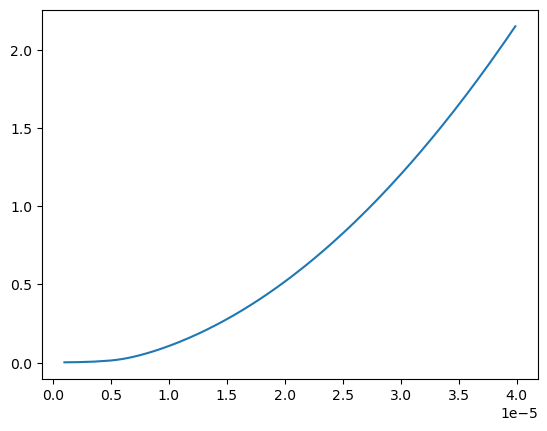

In [21]:
fig, ax = plt.subplots()
ax.plot(arr_resol,rel_error)

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(arr_framerates, rel_error)

In [ ]:
arr_framerates

In [ ]:
df = create_art_vels(kin_Tx, 1200, 1000, 1.0E-11, 60, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)

In [ ]:
t_calc = (np.std(df['vx']))**2 * dust_mass / cnst.k

In [ ]:
np.abs(t_calc - kin_Tx) / kin_Tx

In [ ]:
rel_error

In [ ]:
for i in range(0,no_framerates):
        df = create_art_vels(kin_Tx, 1200, 1000, 1.0E-11, arr_framerates[i], 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
        std_i = np.std(df['vx'])
        arr_discrepSquared_test_framerate[i] = ((kin_Tx - std_i**2 * dust_mass / cnst.k))**2

In [ ]:
np.sqrt(arr_discrepSquared_test_framerate)/kin_Tx*100

In [ ]:
SD

In [ ]:
SDOM 

In [ ]:
arr_resol = np.arange(1E-6,40E-6,1.6E-7)